<a href="https://colab.research.google.com/github/beatricezilli/lust.github.io/blob/main/Example2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Political Communication Strategies on Twitter: Analysis of Engagement, Sentiment, and Emotions of Italian Leaders
This project explores the communication strategies of prominent Italian politicians on Twitter by analyzing the content and engagement metrics of their tweets. Using a combination of statistical and semantic methods, including sentiment and emotion analysis, it provides insights into how each politician engages with their audience and the emotional reactions they provoke. The methodologies employed include data scraping via Twitter’s API, statistical analysis of likes and retweets, linguistic processing, and social network analysis to map user engagement trends and sentiment distribution. This comprehensive approach aims to offer a clearer understanding of the impact of political figures on Twitter.


In [4]:
#Import delle librerie necessarie per il progetto
import pandas as pd #libreria per i dataframe
import networkx.algorithms as nxa
import collections
import networkx as nx #Libreria che si occupa della gestione
import matplotlib.pyplot as plt
import re
import itertools
import statistics
import numpy as np

from wordcloud import WordCloud  #Libreria per la creazione di wordcloud
from collections import Counter
from textblob import TextBlob #libreria non più utilizzata in quanto non comprendeva l'italiano

#Libreria per interfacciarsi con di Twitter
import tweepy
from tweepy import OAuthHandler

#Libreria per eliminare le stopwords, con il downlaod della lingua ialiana e dell'aggiunta di nuove stopwords
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("italian"))
new_stopwords = ["pi", "più","sar","de"]
second_stopwrds = set(stopwords.words("english"))
stop_words = stop_words.union(new_stopwords)
stop_words = stop_words.union(second_stopwrds)
from nltk import bigrams

#Funzione che ci consente di eliminare dai tweets dei caratteri definiti e sostituirli con uno spazio
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

#installazione della libreria che si occupa della sentiment e della emotion analysis
!pip install feel_it
from feel_it import EmotionClassifier, SentimentClassifier

#Dati necessari per l'uso delle api di Twitter
consumer_key = '4EfIh3vwLndcm1mcVKFmCvC0f'
consumer_secret = 'ox5PJzfyyckq6cyczTGL1fksQD46dyHxrkYi4Vrml6v6t7s89p'
access_token = '3751804937-qtMgYjDkwY5YNkDe6xiQbLJgLnuJDtBRC69uSCv'
access_secret = '61loUkJEU4y3fDvOAEbrogh8e5DwxCKvrkiodxRSP7sVb'


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
#uploading twitter data
from google.colab import files
uploaded = files.upload()

Saving dataset2.csv to dataset2.csv
Saving dataset1.csv to dataset1.csv


In [ ]:
#import dataset1
dataset1 = pd.read_csv("dataset1.csv", header = 0)
dataset1

,ID,Tweet,Likes,Retweet,Data
0,GiorgiaMeloni,Arrivano prime condanne dell'inchiesta sullo s...,104,28,2021-11-11 17:10:00
1,GiorgiaMeloni,STOP alle occupazioni abusive. Approvato alla ...,263,51,2021-11-11 16:21:02
2,GiorgiaMeloni,Lo ripeterò all’infinito: l’unico modo per com...,176,30,2021-11-11 14:42:52
3,GiorgiaMeloni,"9mila denunce, 15milioni già intascati dai tru...",284,59,2021-11-11 14:42:50
4,GiorgiaMeloni,Il Ministro della Salute ha mentito sul piano ...,1031,267,2021-11-11 12:02:58
...,...,...,...,...,...
3593,EnricoLetta,Un buon accordo stasera. La #concertazione fa ...,264,38,2021-06-29 20:14:53
3594,EnricoLetta,Auguri di cuore a Giorgio #Napolitano che oggi...,1268,73,2021-06-29 14:54:37
3595,EnricoLetta,Era nel programma con cui son stato eletto Seg...,499,83,2021-06-29 08:58:30
3596,EnricoLetta,Quando #GovernoDraghi annunciò che non avrebbe...,254,42,2021-06-28 17:44:11


In [ ]:
#import dataset2
dataset2 = pd.read_csv("dataset2.csv", header = 0)
dataset2

,ID,Testo,Sentiment,Emotion,Mention
0,円,@matteosalvinimi Sticazzi,negative,anger,@matteosalvinimi
1,birba,@Ludo42854002 @CiaccioSalvo @matteosalvinimi A...,negative,anger,@matteosalvinimi
2,suiYYYiuris,Sicuramente milionario come @Fedez che scende...,negative,anger,@matteosalvinimi
3,Tina,@matteosalvinimi Si dai con la flat tax..cosi ...,negative,anger,@matteosalvinimi
4,Micor55,@matteosalvinimi Passa il decreto anti-frodi \...,negative,anger,@matteosalvinimi
...,...,...,...,...,...
4995,Nopino,@GiorgiaMeloni Questi delinquenti si sentono p...,negative,anger,@EnricoLetta
4996,Kouroukan Fouga,@paolofil2907 @MatteoRichetti @GiorgiaMeloni N...,negative,anger,@EnricoLetta
4997,SKONTRA MILKO,@GiorgiaMeloni Starebbe meglio in un altro pos...,positive,joy,@EnricoLetta
4998,Carlamaria,@SesostriIII @GiorgiaMeloni Non capisco questo...,negative,sadness,@EnricoLetta


In [ ]:
#creating a new variable with "name"
name_column= dataset1["ID"]
name_column= dataset1["Tweet"]
name_column= dataset1["Likes"]
name_column= dataset1["Retweet"]
name_column= dataset1["Data"]

In [ ]:
#funzione che data una tabella cntenente i tweets in cui è menzionato un dato politico esegue la percentuale del numero di tweets con sentimenti positivi-negativi & con le 4 emozioni prese in considerazione
#stampando il tutto su un grafico a torta
def sentiment_emotion(table,name):
  app_1=table[table.Emotion=="fear"]
  app_1=app_1["Testo"]
  fear=round((app_1.shape[0]/table.shape[0])*100,1)
  app_2=table[table.Emotion=="joy"]
  app_2=app_2["Testo"]
  joy=round((app_2.shape[0]/table.shape[0])*100,1)
  app_3=table[table.Emotion=="anger"]
  app_3=app_3["Testo"]
  anger=round((app_3.shape[0]/table.shape[0])*100,1)
  app_4=table[table.Emotion=="sadness"]
  app_4=app_4["Testo"]
  sadness=round((app_4.shape[0]/table.shape[0])*100,1)
  app_5=table[table.Sentiment=="positive"]
  app_5=app_5["Testo"]
  positive=round((app_5.shape[0]/table.shape[0])*100,1)
  #app_6=table[table.Sentiment=="neutral"]
  #app_6=app_6["Testo"]
  #neutral=round((app_6.shape[0]/table.shape[0])*100,1)
  app_7=table[table.Sentiment=="negative"]
  app_7=app_7["Testo"]
  negative=round((app_7.shape[0]/table.shape[0])*100,1)
  labels = ["Fear ["+str(fear)+"%]" , "Joy ["+str(joy)+"%]","Anger ["+str(anger)+"%]","Sadness ["+str(sadness)+"%]"]
  sizes = [fear, joy,anger, sadness]
  colors = ["green", "yellow","red","blue"]
  patches, texts = plt.pie(sizes,colors=colors, startangle=90)
  plt.style.use("default")
  plt.legend(labels)
  plt.title("Emotion recognition " +str(name)+ " in percentuale")
  plt.axis("equal")
  plt.show()
  labels = ["Positive ["+str(positive)+"%]" ,"Negative ["+str(negative)+"%]"] #"Neutrali ["+str(neutral)+"%]"
  sizes = [positive, negative] #neutral, negative]
  colors = ["green","red"] #, "yellow"
  patches, texts = plt.pie(sizes,colors=colors, startangle=90)
  plt.style.use("default")
  plt.legend(labels)
  plt.title("Sentiment Analysis of "+str(name)+"'s tweets  in percentuale")
  plt.axis("equal")
  plt.show()

In [ ]:
#funzione che data una tabella contenente i tweets in cui è menzionato un dato politico esegue il conteggio dei singoli tweets con sentimenti positivi-negativi & con le 4 emozioni prese in considerazione
#stampando il tutto su un grafico a barre orizzontali per poterle confrontare
def grafici_num(table,name):
  plt.figure(figsize=(8,6))
  table["Sentiment"].value_counts()
  table["Sentiment"].value_counts().plot(kind="barh")
  plt.title("Number of Positive and negative tweets of: " +str(name))
  plt.show()
  plt.figure(figsize=(8,6))
  table["Emotion"].value_counts()
  table["Emotion"].value_counts().plot(kind="barh")
  plt.title("Numero di tweets felici, tristi e impauriti riferiti a " +str(name))
  plt.show()

In [ ]:
#Limite massimo di tweets da prendere per singolo esponente politico
num_max_tweets=1000

In [ ]:
#Dichiarazioni delle liste che conterranno il contenuto dei tweet, la data e il numero di likes
testo=[]
nlike=[]
day=[]
rtc=[]
twn=[]

In [ ]:
#Lista dei politici analizzati
list_polit=["GiorgiaMeloni","matteosalvinimi","luigidimaio","GiuseppeConteIT","EnricoLetta"]

In [ ]:
#Dichiarazione di parte delle variabili utilizzate nel progetto
like_tot=[]
retweets_tot=[]
user_base=[]
perc_user_like=[]
perc_user_ret=[]
appoggio=[]
appoggio3=[]
like_activity=[]
re_activity=[]

tweet_meloni=[]
meloni_norm=[]
lista_meloni=[]
token_meloni=[]
contatore_parole_meloni=[]
appoggio_meloni=[]

tweet_salvini=[]
salvini_norm=[]
lista_salvini=[]
token_salvini=[]
contatore_parole_salvini=[]
appoggio_salvini=[]

tweet_dimaio=[]
dimaio_norm=[]
lista_dimaio=[]
token_dimaio=[]
contatore_parole_dimaio=[]
appoggio_dimaio=[]

tweet_conte=[]
conte_norm=[]
lista_conte=[]
token_conte=[]
contatore_parole_conte=[]
appoggio_conte=[]

tweet_letta=[]
letta_norm=[]
lista_letta=[]
token_letta=[]
contatore_parole_letta=[]
appoggio_letta=[]

char_letta=0
char_meloni=0
char_salvini=0
char_dimaio=0
char_conte=0
tot_nu=0

In [ ]:
#visualizing content of the dataframe
dataset1[["ID","Tweet","Likes","Retweet","Data"]]

#deleting limit of tweets
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
testo.extend(dataset1["Tweet"].tolist())
nlike.extend(dataset1["Likes"].tolist())
day.extend(dataset1["Data"].tolist())
rtc.extend(dataset1["Retweet"].tolist())
twn.extend(dataset1["ID"].tolist())

In [ ]:
#Usando le funzioni di Pandas si richiama a schermo una tabella con la media dei likes e dei retweet
media_like_rt = dataset1.groupby("ID")[['Retweet', 'Likes']].mean()
media_like_rt

,Retweet,Likes
ID,,
EnricoLetta,76.979381,715.177835
GiorgiaMeloni,207.343675,1192.361575
GiuseppeConteIT,509.418699,3525.113821
luigidimaio,109.654206,556.479751
matteosalvinimi,113.607863,722.295363


In [ ]:
#Usando le funzioni di Pandas si richiama a schermo una tabella con la mediana dei likes e dei retweet
mediana_like_rt=dataset1.groupby("ID")[['Retweet', 'Likes']].median()
mediana_like_rt

,Retweet,Likes
ID,,
EnricoLetta,34.0,265.5
GiorgiaMeloni,164.5,997.0
GiuseppeConteIT,280.0,1735.5
luigidimaio,81.0,431.5
matteosalvinimi,71.0,516.5


In [ ]:
#Trasferimento dei dati presenti nella precedente tabella delle medie in variabili appoggio così da poter creare un grafico
tab_likes_letta = media_like_rt.values[0][0]
tab_likes_meloni = media_like_rt.values[1][0]
tab_likes_conte = media_like_rt.values[2][0]
tab_likes_maio = media_like_rt.values[3][0]
tab_likes_salvini =  media_like_rt.values[4][0]
tab_rt_letta = media_like_rt.values[0][1]
tab_rt_meloni = media_like_rt.values[1][1]
tab_rt_conte = media_like_rt.values[2][1]
tab_rt_maio = media_like_rt.values[3][1]
tab_rt_salvini =  media_like_rt.values[4][1]

In [ ]:
#Trasferimento dei dati presenti nella precedente tabella della mediana in variabili appoggio così da poter creare un grafico
tab1_likes_letta = mediana_like_rt.values[0][0]
tab1_likes_meloni = mediana_like_rt.values[1][0]
tab1_likes_conte = mediana_like_rt.values[2][0]
tab1_likes_maio = mediana_like_rt.values[3][0]
tab1_likes_salvini =  mediana_like_rt.values[4][0]
tab1_rt_letta = mediana_like_rt.values[0][1]
tab1_rt_meloni = mediana_like_rt.values[1][1]
tab1_rt_conte = mediana_like_rt.values[2][1]
tab1_rt_maio = mediana_like_rt.values[3][1]
tab1_rt_salvini = mediana_like_rt.values[4][1]


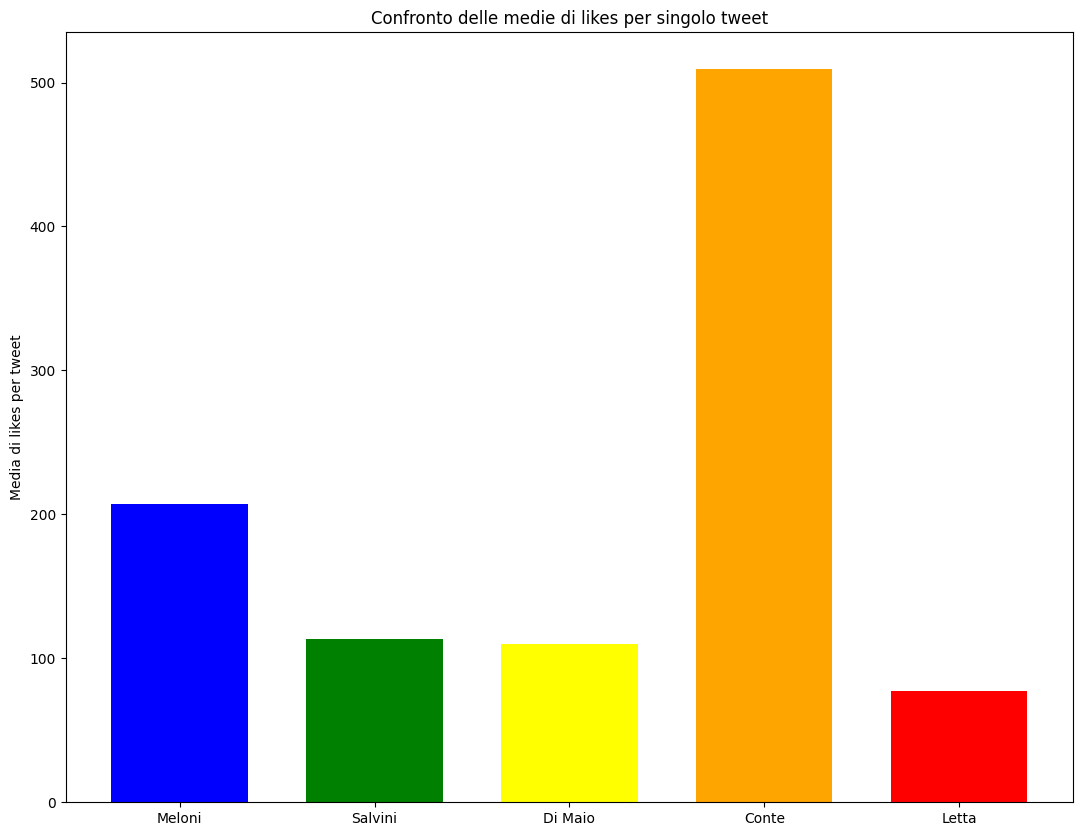

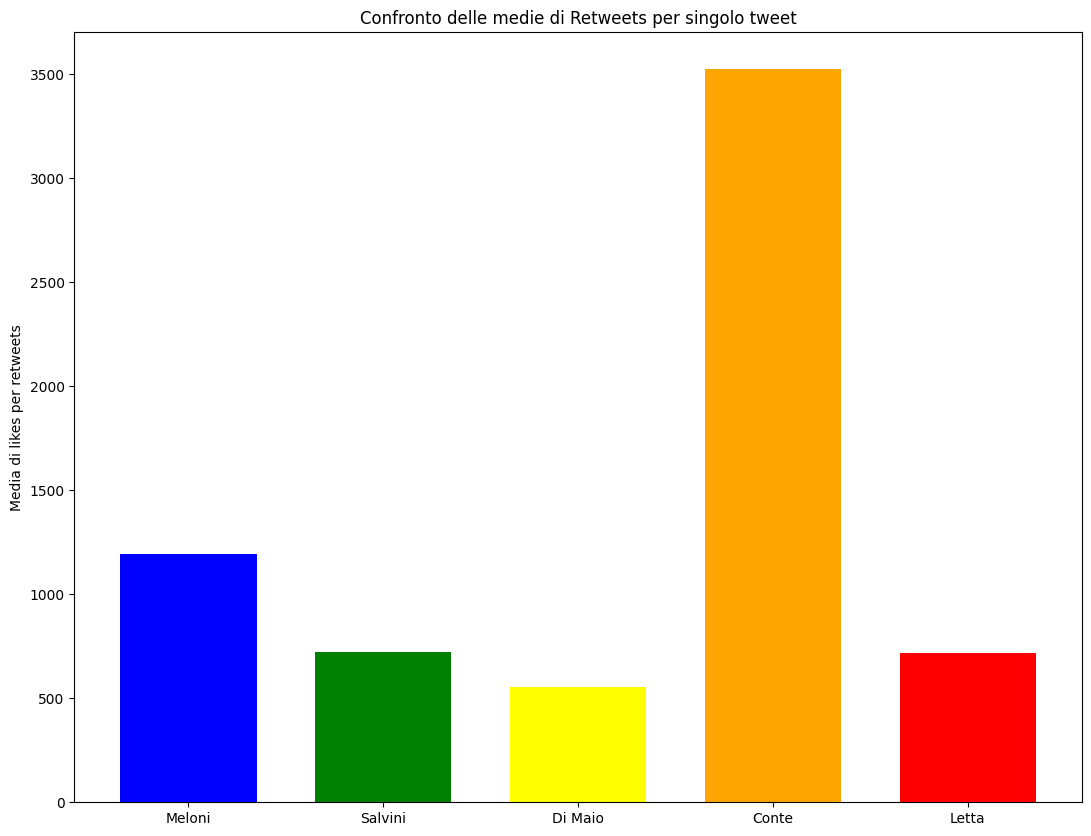

In [ ]:
#Istruzioni per la stampa dei grafici per confronto delle medie di Like e Retweets per un singolo tweet
f, ax = plt.subplots(figsize=(13,10))
croma=["blue","green","yellow","orange","red"] #Scelta del colore
x=["Meloni","Salvini","Di Maio","Conte","Letta"] #Posizionamento dei nomi sull'asse X
y=[tab_likes_meloni, tab_likes_salvini, tab_likes_maio, tab_likes_conte, tab_likes_letta] #Posizionamento dei valori sull'asse Y
plt.bar(x,y, width=0.7, color=croma)
plt.ylabel("Media di likes per tweet")
plt.title("Confronto delle medie di likes per singolo tweet")
plt.show()

f, ax = plt.subplots(figsize=(13,10))
croma=["blue","green","yellow","orange","red"]
x=["Meloni","Salvini","Di Maio","Conte","Letta"]
y=[tab_rt_meloni, tab_rt_salvini, tab_rt_maio, tab_rt_conte, tab_rt_letta]
plt.bar(x,y, width=0.7, color=croma)
plt.ylabel("Media di likes per retweets")
plt.title("Confronto delle medie di Retweets per singolo tweet")
plt.show()

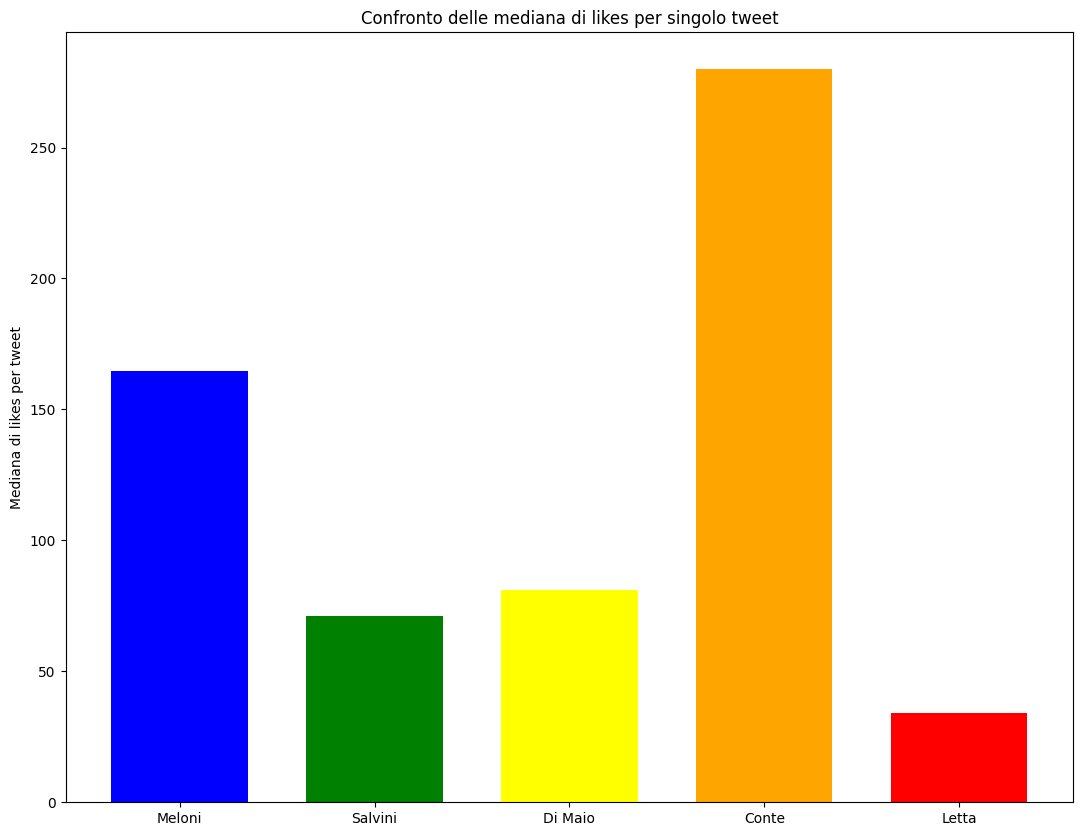

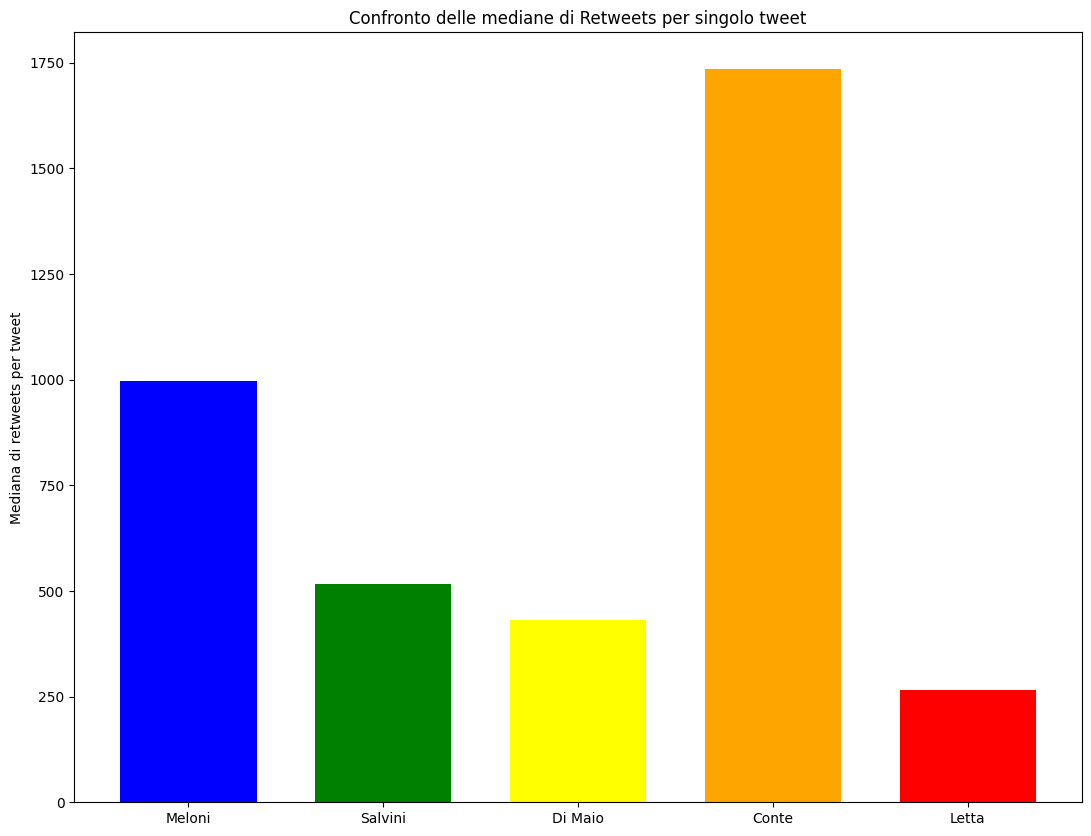

In [ ]:
#Grafici per confronto delle mediane di Like e Retweets per un singolo tweet
f, ax = plt.subplots(figsize=(13,10))
croma=["blue","green","yellow","orange","red"]
x=["Meloni","Salvini","Di Maio","Conte","Letta"]
y=[tab1_likes_meloni, tab1_likes_salvini, tab1_likes_maio, tab1_likes_conte, tab1_likes_letta]
plt.bar(x,y, width=0.7, color=croma)
plt.ylabel("Mediana di likes per tweet")
plt.title("Confronto delle mediana di likes per singolo tweet")
plt.show()

f, ax = plt.subplots(figsize=(13,10))
croma=["blue","green","yellow","orange","red"]
x=["Meloni","Salvini","Di Maio","Conte","Letta"]
y=[tab1_rt_meloni, tab1_rt_salvini, tab1_rt_maio, tab1_rt_conte, tab1_rt_letta]
plt.bar(x,y, width=0.7, color=croma)
plt.ylabel("Mediana di retweets per tweet")
plt.title("Confronto delle mediane di Retweets per singolo tweet")
plt.show()

In [ ]:
#Blocco che calcola la media della lunghezza dei tweet

#Tramite il ciclo for viene fatta scorrere la variabile che contiene gli ID dei profili
#se viene trovata corrispondenza tra l'ID e il nome del politico viene aggiornato un contatore e una variabile in cui si aggiunge la lunghezza del testo sommata alla variabile stessa.
#A fine ciclo il contatore ci permette di sapere quanti post erano stati scritti da un singolo politico così da poter trarne la media.

for j in range(len(twn)):
  if twn[j]=="EnricoLetta":
    tot_nu=tot_nu+1
    char_letta=char_letta+len(testo[j])

media_char_letta=char_letta/tot_nu

tot_nu=0
for j in range(len(twn)):
  if twn[j]=="matteosalvinimi":
    tot_nu=tot_nu+1
    char_salvini=char_salvini+len(testo[j])

media_char_salvini=char_salvini/tot_nu

tot_nu=0
for j in range(len(twn)):
  if twn[j]=="GiorgiaMeloni":
    tot_nu=tot_nu+1
    char_meloni=char_meloni+len(testo[j])

media_char_meloni=char_meloni/tot_nu

tot_nu=0
for j in range(len(twn)):
  if twn[j]=="luigidimaio":
    tot_nu=tot_nu+1
    char_dimaio=char_dimaio+len(testo[j])

media_char_dimaio=char_dimaio/tot_nu

tot_nu=0
for j in range(len(twn)):
  if twn[j]=="GiuseppeConteIT":
    tot_nu=tot_nu+1
    char_conte=char_conte+len(testo[j])

media_char_conte=char_conte/tot_nu

In [ ]:
#Stampa delle medie
print("Meloni: "+str(media_char_meloni))
print("Salvini: "+str(media_char_salvini))
print("Di Maio: "+str(media_char_dimaio))
print("Conte: "+str(media_char_conte))
print("Letta: "+str(media_char_letta))


Meloni: 235.30310262529832
Salvini: 188.56350806451613
Di Maio: 209.92523364485982
Conte: 194.5487804878049
Letta: 167.61855670103094


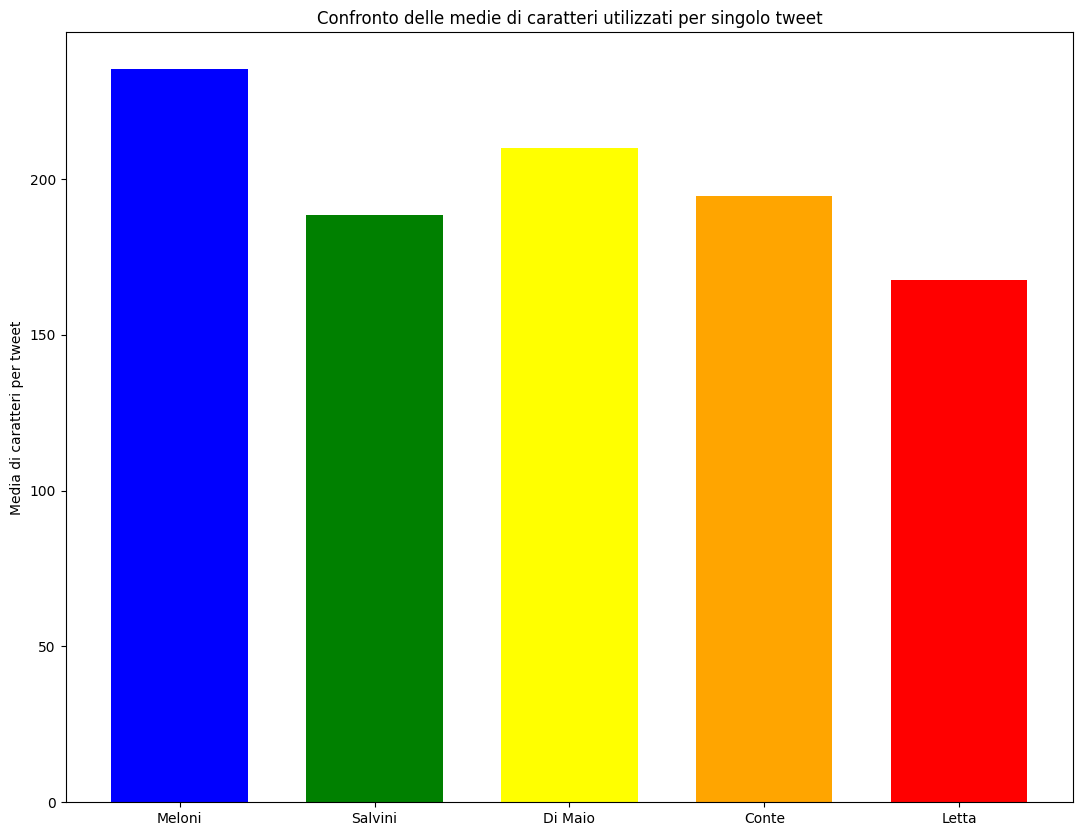

In [ ]:
#Visualizzazione delle medie su un diagramma a barre
f, ax = plt.subplots(figsize=(13,10))
croma=["blue","green","yellow","orange","red"]
x=["Meloni","Salvini","Di Maio","Conte","Letta"]
y=[media_char_meloni, media_char_salvini, media_char_dimaio, media_char_conte, media_char_letta]
plt.bar(x,y, width=0.7, color=croma)
plt.ylabel("Media di caratteri per tweet")
plt.title("Confronto delle medie di caratteri utilizzati per singolo tweet")
plt.show()


In [ ]:
#Tramite Pandas si richiama la top 10 dei tweets più likati
top10=dataset1.loc[dataset1.Likes.nlargest(10).index]
top10


,ID,Tweet,Likes,Retweet,Data
2669,GiuseppeConteIT,Io sto con #Fedez. Nessuna censura. https://t....,56709,8688,2021-05-02 09:30:32
2952,GiuseppeConteIT,Silvia Romano è stata liberata! Ringrazio le d...,53488,10376,2020-05-09 15:17:31
2766,GiuseppeConteIT,Congratulations to the American people and ins...,45247,5815,2020-11-07 18:13:35
2655,GiuseppeConteIT,Complimenti ai @thisisManeskin per la vittoria...,31117,3326,2021-05-22 23:00:11
3027,GiuseppeConteIT,"Ognuno di noi, con la propria determinazione, ...",31056,6774,2020-03-14 18:00:30
2998,GiuseppeConteIT,Grazie 🇦🇱 https://t.co/l5JcDMhRYr,29734,4908,2020-03-29 11:11:55
2999,GiuseppeConteIT,L'Unione europea ha un appuntamento con la sto...,27724,4623,2020-03-28 20:18:57
2628,GiuseppeConteIT,L’Italia sul tetto d’Europa!!!\nDopo tante sof...,26910,3266,2021-07-11 22:22:16
2981,GiuseppeConteIT,Grazie a ognuno di voi. Insieme ce la faremo 🇮...,26482,4545,2020-04-11 13:38:16
2949,GiuseppeConteIT,"Bentornata in Italia, Silvia! https://t.co/aWy...",25483,2689,2020-05-10 13:13:17


In [ ]:
#Tramite Pandas si richiama la bottom 10 dei tweets meno likati
bot10=dataset1.loc[dataset1.Likes.nsmallest(10).index]
bot10

,ID,Tweet,Likes,Retweet,Data
3541,EnricoLetta,@tommibatti00 @alessandroTuzzo @agora_dem @pdn...,1,0,2021-07-17 15:58:09
3542,EnricoLetta,@MrAndrewQ @agora_dem Grazie per esserti iscri...,1,0,2021-07-17 15:56:25
3545,EnricoLetta,@tommibatti00 @alessandroTuzzo Tommaso la invi...,2,0,2021-07-17 13:24:10
3539,EnricoLetta,@MabIvo Veramente l’Agorà era nella Grecia ant...,4,0,2021-07-17 16:22:36
3538,EnricoLetta,@espositopasqual @pdnetwork @agora_dem @Senato...,6,1,2021-07-17 16:27:04
3540,EnricoLetta,@espositopasqual @pdnetwork @agora_dem @Senato...,6,2,2021-07-17 16:09:26
3211,EnricoLetta,Su ⁦@RepubblicaTv⁩ parliamo di ⁦@agora_dem⁩ co...,10,3,2021-11-10 17:25:39
3332,EnricoLetta,Comment rendre les jeunes acteurs du changemen...,19,3,2021-09-30 13:58:12
3347,EnricoLetta,Congratulations! Looking forward to cooperatin...,19,4,2021-09-29 07:16:38
3548,EnricoLetta,@latwittipe Le @agora_dem per avere un @pdnetw...,21,1,2021-07-17 11:48:00


In [ ]:
#Codice per la raccolta e la tokenizzazione delle parole di ogni singolo esponente
#al fine di poter calcolare quali sono le più utilizzate.

#L'array scorre l'intera variabile che contiene gli ID dei Tweets, entrando
#nell'if quando viene trovato il nome desiderato. Qui, tramite la funzione
#append viene viene collocata in una variabile il testo del singolo tweet.
for i in range(len(twn)):
  if twn[i]=="GiorgiaMeloni":
    tweet_meloni.append(testo[i])

for i in range(len(twn)):
  if twn[i]=="matteosalvinimi":
    tweet_salvini.append(testo[i])

for i in range(len(twn)):
  if twn[i]=="luigidimaio":
    tweet_dimaio.append(testo[i])

for i in range(len(twn)):
  if twn[i]=="GiuseppeConteIT":
    tweet_conte.append(testo[i])

for i in range(len(twn)):
  if twn[i]=="EnricoLetta":
    tweet_letta.append(testo[i])


In [ ]:
#La variabile precedentemente creata, contenente tutti i tweets del singolo
#esponente politico viene ora "normalizzata". Dal testo vengono rimossi
#caratteri speciali, richiamando la funzione dichiarata all'inizio ed eventuali
#link. Poi tutte le parole vengono rese in minuscolo per evitare ripetizioni.
#Inoltre, vengono eliminate le stopwords e poi contante le singole parole per
#poi inserire in un dataframe le 10 parole più comuni.

meloni_norm=[remove_url(tweet_meloni) for tweet_meloni in tweet_meloni]  #Rimozione URL e caratteri speciali.
lista_meloni=[meloni_norm.lower().split() for meloni_norm in meloni_norm] #Messa in minuscolo.
for tutte_par in lista_meloni: #Climinazione delle stopwords.
    for tweet_meloni in tutte_par:
      token_meloni = [[parola for parola in lista_meloni if not parola in stop_words]
              for lista_meloni in lista_meloni]
appoggio_meloni= list(itertools.chain(*token_meloni))  #Creazione di una lista delle parole.
contatore_parole_meloni = collections.Counter(appoggio_meloni) #Conteggio delle ripetizioni.
tabella_meloni_parole = pd.DataFrame(contatore_parole_meloni.most_common(10), columns=['Parole', 'Ripetizioni']) #Creazione della tabella.

salvini_norm=[remove_url(tweet_salvini) for tweet_salvini in tweet_salvini]
lista_salvini=[salvini_norm.lower().split() for salvini_norm in salvini_norm]
for tutte_par in lista_salvini:
    for tweet_salvini in tutte_par:
      token_salvini = [[parola for parola in lista_salvini if not parola in stop_words]
              for lista_salvini in lista_salvini]
appoggio_salvini = list(itertools.chain(*token_salvini))
contatore_parole_salvini = collections.Counter(appoggio_salvini)
tabella_salvini_parole = pd.DataFrame(contatore_parole_salvini.most_common(10), columns=['Parole', 'Ripetizioni'])

dimaio_norm=[remove_url(tweet_dimaio) for tweet_dimaio in tweet_dimaio]
lista_dimaio=[dimaio_norm.lower().split() for dimaio_norm in dimaio_norm]
for tutte_par in lista_dimaio:
    for tweet_dimaio in tutte_par:
      token_dimaio = [[parola for parola in lista_dimaio if not parola in stop_words]
              for lista_dimaio in lista_dimaio]
appoggio_dimaio = list(itertools.chain(*token_dimaio))
contatore_parole_dimaio = collections.Counter(appoggio_dimaio)
tabella_dimaio_parole = pd.DataFrame(contatore_parole_dimaio.most_common(10), columns=['Parole', 'Ripetizioni'])

conte_norm=[remove_url(tweet_conte) for tweet_conte in tweet_conte]
lista_conte=[conte_norm.lower().split() for conte_norm in conte_norm]
for tutte_par in lista_conte:
    for tweet_conte in tutte_par:
      token_conte = [[parola for parola in lista_conte if not parola in stop_words]
              for lista_conte in lista_conte]
appoggio_conte = list(itertools.chain(*token_conte))
contatore_parole_conte = collections.Counter(appoggio_conte)
tabella_conte_parole = pd.DataFrame(contatore_parole_conte.most_common(10), columns=['Parole', 'Ripetizioni'])

letta_norm=[remove_url(tweet_letta) for tweet_letta in tweet_letta]
lista_letta=[letta_norm.lower().split() for letta_norm in letta_norm]
for tutte_par in lista_letta:
    for tweet_letta in tutte_par:
      token_letta = [[parola for parola in lista_letta if not parola in stop_words]
              for lista_letta in lista_letta]
appoggio_letta = list(itertools.chain(*token_letta))
contatore_parole_letta = collections.Counter(appoggio_letta)
tabella_letta_parole = pd.DataFrame(contatore_parole_letta.most_common(10), columns=['Parole', 'Ripetizioni'])


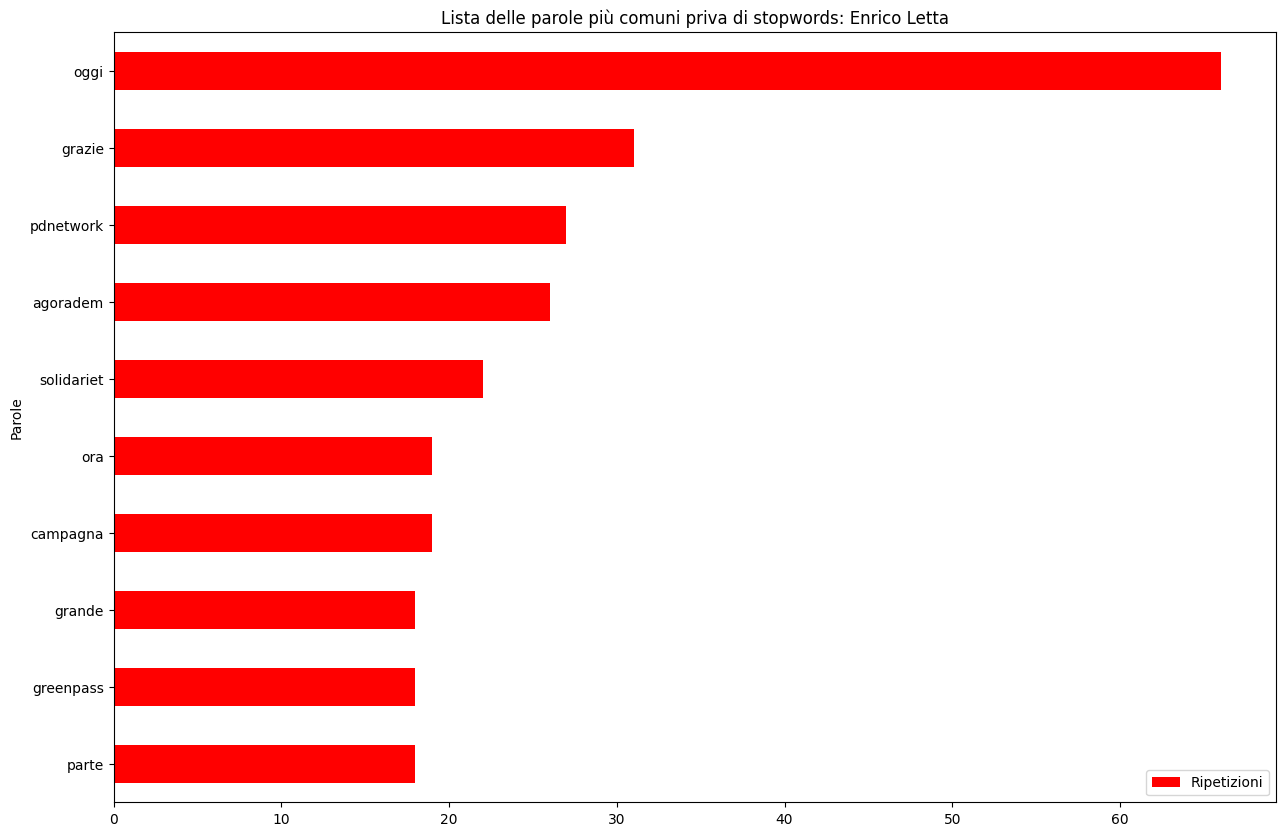

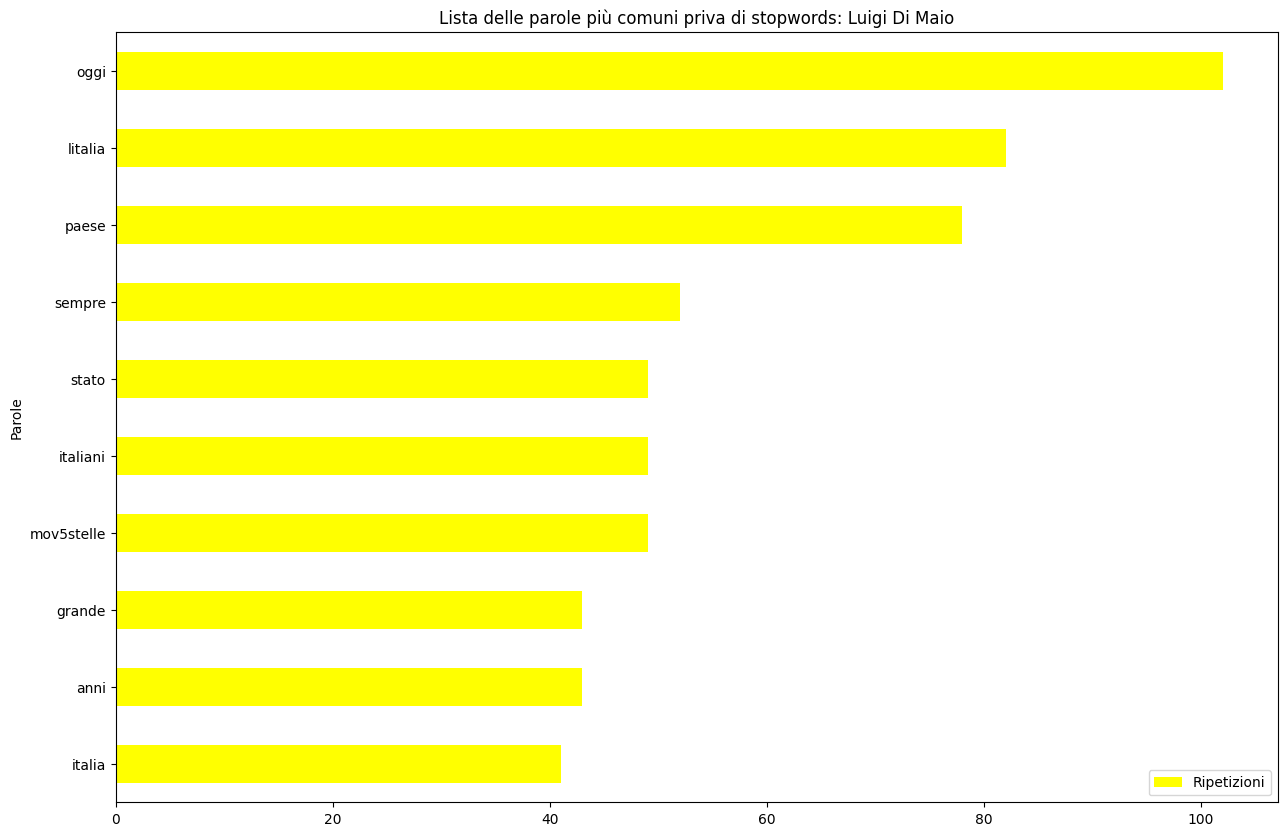

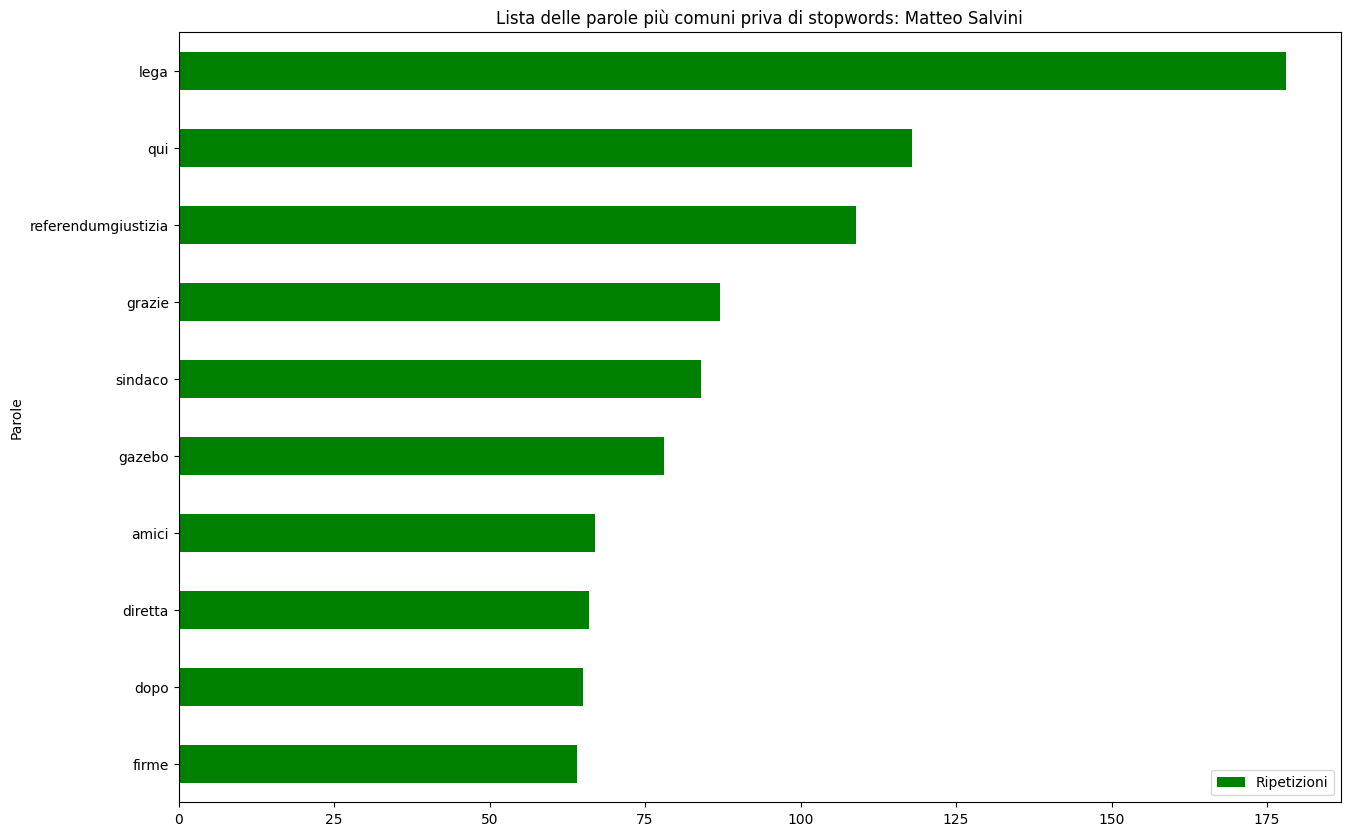

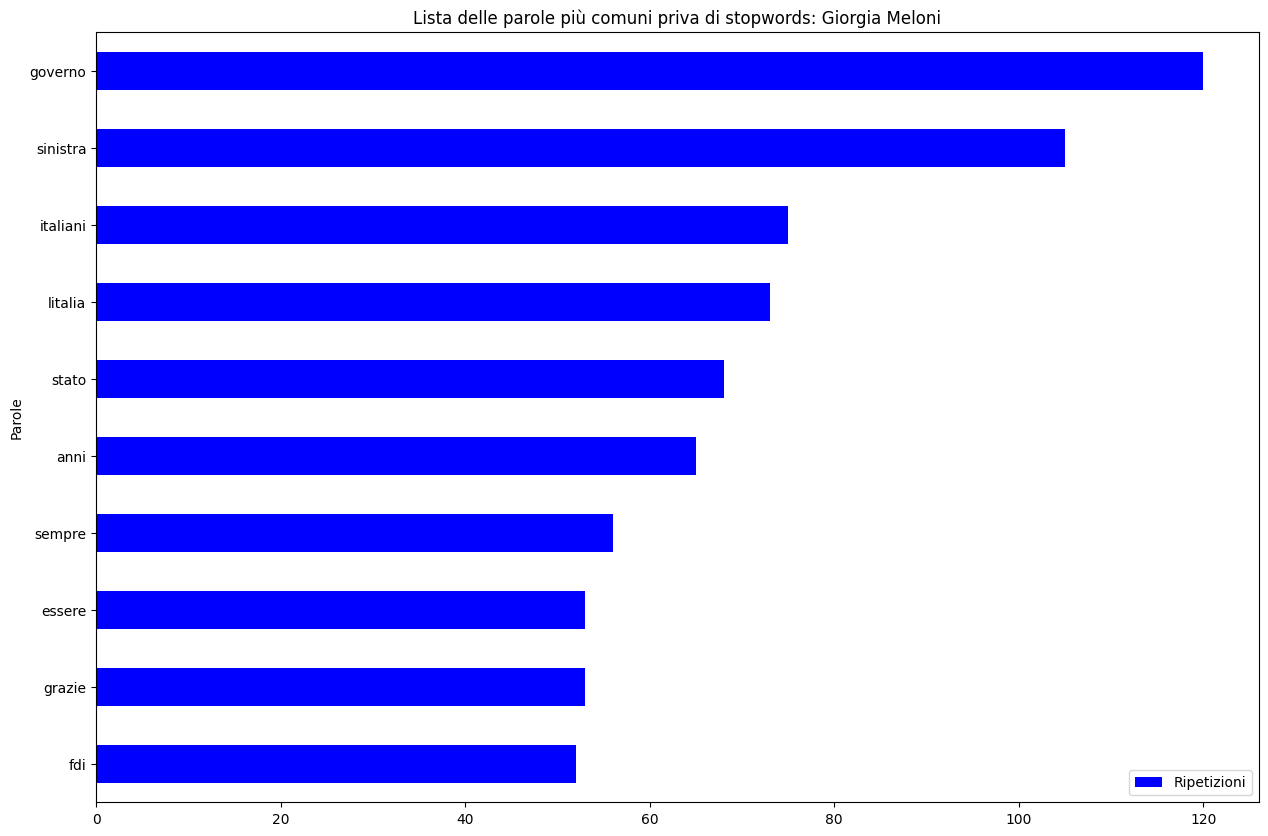

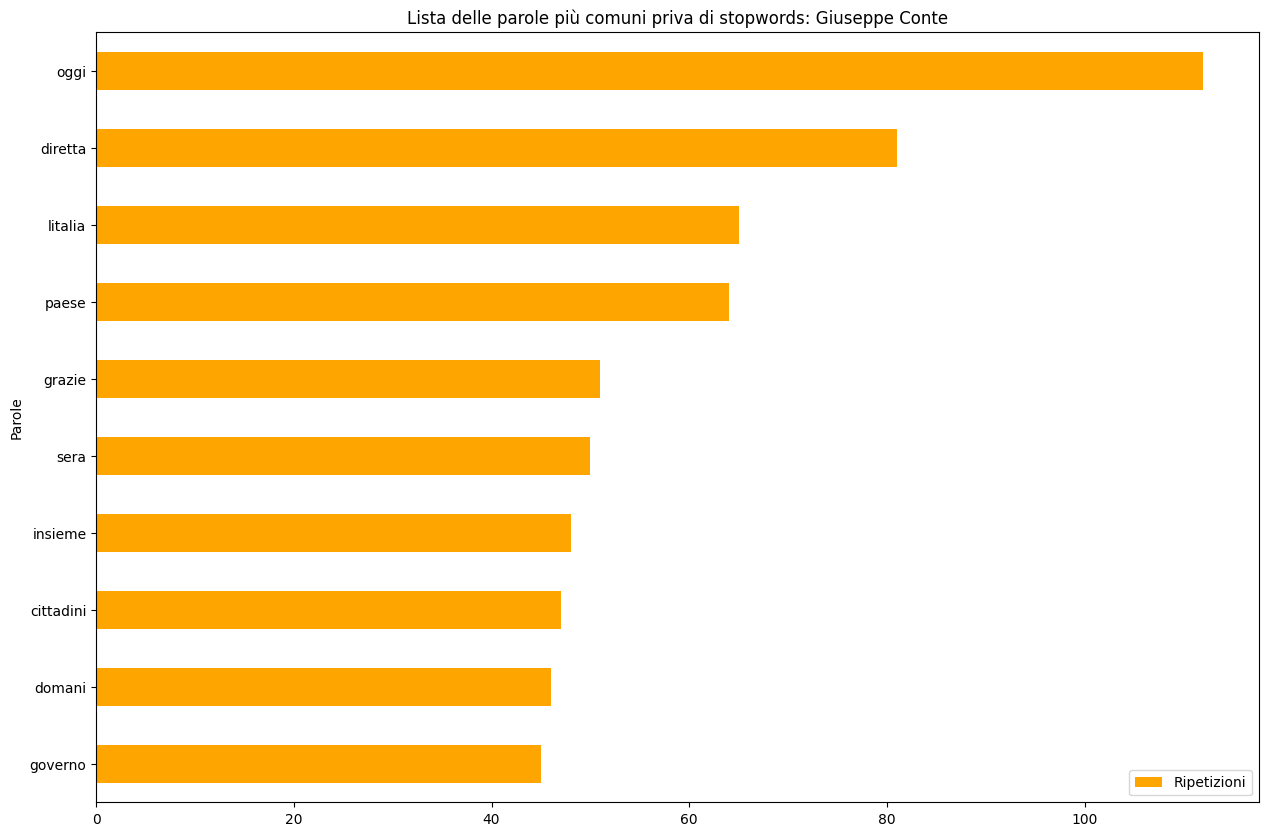

,Parole,Ripetizioni
0,oggi,112
1,diretta,81
2,litalia,65
3,paese,64
4,grazie,51
5,sera,50
6,insieme,48
7,cittadini,47
8,domani,46
9,governo,45


In [ ]:
#Grafici dei singoli esponenti con le dieci parole più utilizzate.

fig, ax = plt.subplots(figsize=(15, 10))
tabella_letta_parole.sort_values(by='Ripetizioni').plot.barh(x='Parole',y='Ripetizioni',ax=ax,color="red")
ax.set_title("Lista delle parole più comuni priva di stopwords: Enrico Letta")
plt.show()
fig, ax = plt.subplots(figsize=(15, 10))
tabella_dimaio_parole.sort_values(by='Ripetizioni').plot.barh(x='Parole',y='Ripetizioni',ax=ax,color="yellow")
ax.set_title("Lista delle parole più comuni priva di stopwords: Luigi Di Maio")
plt.show()
fig, ax = plt.subplots(figsize=(15, 10))
tabella_salvini_parole.sort_values(by='Ripetizioni').plot.barh(x='Parole',y='Ripetizioni',ax=ax,color="green")
ax.set_title("Lista delle parole più comuni priva di stopwords: Matteo Salvini")
plt.show()
fig, ax = plt.subplots(figsize=(15, 10))
tabella_meloni_parole.sort_values(by='Ripetizioni').plot.barh(x='Parole',y='Ripetizioni',ax=ax,color="blue")
ax.set_title("Lista delle parole più comuni priva di stopwords: Giorgia Meloni")
plt.show()
fig, ax = plt.subplots(figsize=(15, 10))
tabella_conte_parole.sort_values(by='Ripetizioni').plot.barh(x='Parole',y='Ripetizioni',ax=ax,color="orange")
ax.set_title("Lista delle parole più comuni priva di stopwords: Giuseppe Conte")
plt.show()

tabella_letta_parole #Tabella con la top 10 delle parole utilizzate da Letta

tabella_salvini_parole  #Tabella con la top 10 delle parole utilizzate da Letta

tabella_dimaio_parole #Tabella con la top 10 delle parole utilizzate da Letta

tabella_meloni_parole #Tabella con la top 10 delle parole utilizzate da Letta

tabella_conte_parole #Tabella con la top 10 delle parole utilizzate da Letta


In [ ]:
#L'operazione prima eseguita per ogni singolo esponente politico viene qui invece
#fatta per la totalità dei Tweets così da vedere in maniera globale la top 10
#delle parole più utilizzate.

dati_norm=[remove_url(testo) for testo in testo]
lista_parole=[dati_norm.lower().split() for dati_norm in dati_norm]
for tutte_par in lista_parole:
    for testo in tutte_par:
      parole_singole = [[parola for parola in lista_parole if not parola in stop_words]
              for lista_parole in lista_parole]
appoggio2 = list(itertools.chain(*parole_singole))
contatore_parole = collections.Counter(appoggio2)
risultato_fin = pd.DataFrame(contatore_parole.most_common(10),columns=['Parole', 'Ripetizioni'])
risultato_fin


,Parole,Ripetizioni
0,oggi,381
1,litalia,266
2,grazie,258
3,governo,225
4,italiani,207
5,anni,193
6,paese,189
7,lavoro,187
8,diretta,186
9,stato,182


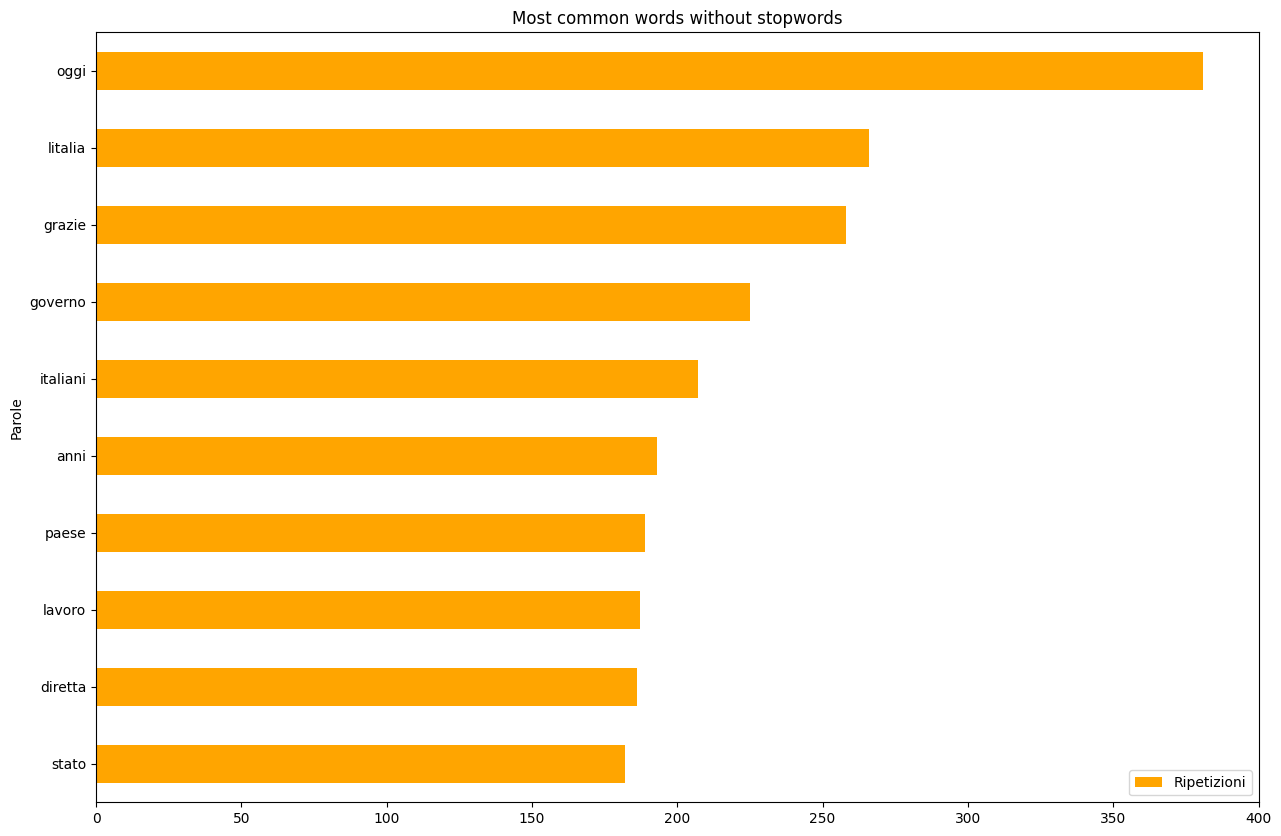

In [ ]:
#Stampa del grafico con la lista delle 10 parole più comuni nella totalità dei tweets.

fig, ax = plt.subplots(figsize=(15, 10))
risultato_fin.sort_values(by='Ripetizioni').plot.barh(x='Parole',y='Ripetizioni',ax=ax,color="orange")
ax.set_title("Most common words without stopwords")
plt.show()

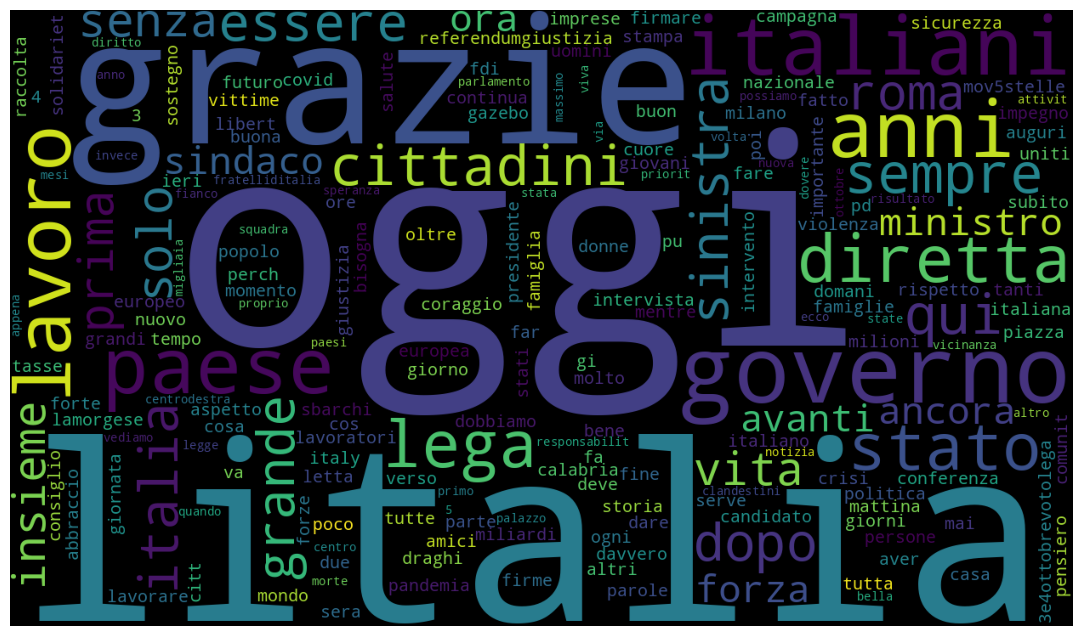

In [ ]:
conteggio=Counter(contatore_parole) #Variabile contenente il conteggio della ripetizione delle parole, realizzata tramite l'ausilio della libreria collections
wordcloud = WordCloud(width = 1250, height = 725).generate_from_frequencies(conteggio) #creazione del wordcloud, assegnazione delle dimensioni e della variabile da cui trarre i dati
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

In [ ]:
# Read data from the CSV file
df = pd.read_csv('dataset2.csv')

testo_mention_salvini = df[df['ID'] == '@matteosalvinimi']['Testo'].tolist()
name_lista_salvini = df[df['ID'] == '@matteosalvinimi']['ID'].tolist()
mention_sal_tab = pd.DataFrame({"ID": name_lista_salvini, "Tweet": testo_mention_salvini})

testo_mention_mel = df[df['ID'] == '@GiorgiaMeloni']['Testo'].tolist()
name_lista_mel = df[df['ID'] == '@GiorgiaMeloni']['ID'].tolist()
mention_mel_tab = pd.DataFrame({"ID": name_lista_mel, "Tweet": testo_mention_mel})

testo_mention_let = df[df['ID'] == '@EnricoLetta']['Testo'].tolist()
name_lista_let = df[df['ID'] == '@EnricoLetta']['ID'].tolist()
mention_let_tab = pd.DataFrame({"ID": name_lista_let, "Tweet": testo_mention_let})

testo_mention_cont = df[df['ID'] == '@GiuseppeConteIT']['Testo'].tolist()
name_lista_cont = df[df['ID'] == '@GiuseppeConteIT']['ID'].tolist()
mention_cont_tab = pd.DataFrame({"ID": name_lista_cont, "Tweet": testo_mention_cont})

testo_mention_maio = df[df['ID'] == '@luigidimaio']['Testo'].tolist()
name_lista_maio = df[df['ID'] == '@luigidimaio']['ID'].tolist()
mention_maio_tab = pd.DataFrame({"ID": name_lista_maio, "Tweet": testo_mention_maio})

In [12]:
# Read data from the CSV file
dataset2 = pd.read_csv('dataset2.csv')
dataset2

,ID,Testo,Sentiment,Emotion,Mention
0,円,@matteosalvinimi Sticazzi,negative,anger,@matteosalvinimi
1,birba,@Ludo42854002 @CiaccioSalvo @matteosalvinimi A...,negative,anger,@matteosalvinimi
2,suiYYYiuris,Sicuramente milionario come @Fedez che scende...,negative,anger,@matteosalvinimi
3,Tina,@matteosalvinimi Si dai con la flat tax..cosi ...,negative,anger,@matteosalvinimi
4,Micor55,@matteosalvinimi Passa il decreto anti-frodi \...,negative,anger,@matteosalvinimi
5,Andrea Raimondi,@matteosalvinimi 9 mila romeni per 20 milioni ...,negative,anger,@matteosalvinimi
6,Umberto R,@Fafene @matteosalvinimi Perché perderebbe con...,negative,anger,@matteosalvinimi
7,Anny,@matteosalvinimi La vergogna siete voi che ave...,negative,anger,@matteosalvinimi
8,Effatá _ Gerardo,@matteosalvinimi Se lavora come ha lavorato co...,negative,anger,@matteosalvinimi
9,MARK FLEMING,@IlPrimatoN Questo dimostra che @matteosalvini...,negative,anger,@matteosalvinimi


In [13]:
#visualizing content of the dataframe
dataset2[["ID","Testo","Sentiment","Emotion","Mention"]]

#deleting limit of tweets
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [22]:
text = dataset2["Testo"].tolist()
sent = dataset2["Sentiment"].tolist()
emo = dataset2["Emotion"].tolist()
men = dataset2["Mention"].tolist()
id = dataset2["ID"].tolist()

In [25]:
#taking the tweets that mention the politicians
testo_mention_salvini = dataset2[dataset2['Mention'] == '@matteosalvinimi']['Testo'].tolist()
testo_mention_meloni = dataset2[dataset2['Mention'] == '@GiorgiaMeloni']['Testo'].tolist()
testo_mention_letta = dataset2[dataset2['Mention'] == '@EnricoLetta']['Testo'].tolist()
testo_mention_dimaio = dataset2[dataset2['Mention'] == '@luigidimaio']['Testo'].tolist()
testo_mention_conte = dataset2[dataset2['Mention'] == '@GiuseppeConteIT']['Testo'].tolist()

In [ ]:
#Blocco che esegue la emotion analysis con l'ausilio della libreria preposta
emo=EmotionClassifier()
emotion_salvini=emo.predict(testo_mention_salvini)
emotion_letta=emo.predict(testo_mention_let)
emotion_meloni=emo.predict(testo_mention_mel)
emotion_maio=emo.predict(testo_mention_maio)
emotion_conte=emo.predict(testo_mention_cont)

#Blocco che esegue la sentiment analysis con l'ausilio della libreria preposta
sent=SentimentClassifier()
sentiment_salvini=sent.predict(testo_mention_salvini)
sentiment_letta=sent.predict(testo_mention_let)
sentiment_meloni=sent.predict(testo_mention_mel)
sentiment_maio=sent.predict(testo_mention_maio)
sentiment_conte=sent.predict(testo_mention_cont)

tokenizer.json:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/299 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]